## This is the 2-layer neural network workbook for ECE 247 Assignment #3

Please follow the notebook linearly to implement a two layer neural network.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a two layer neural network.

In [94]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Toy example

Before loading CIFAR-10, there will be a toy example to test your implementation of the forward and backward pass

In [95]:
from nndl.neural_net import TwoLayerNet

In [96]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

### Compute forward pass scores

In [98]:
## Implement the forward pass of the neural network.

# Note, there is a statement if y is None: return scores, which is why 
# the following call will calculate the scores.
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
    [-1.07260209,  0.05083871, -0.87253915],
    [-2.02778743, -0.10832494, -1.52641362],
    [-0.74225908,  0.15259725, -0.39578548],
    [-0.38172726,  0.10835902, -0.17328274],
    [-0.64417314, -0.18886813, -0.41106892]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

correct scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

Difference between your scores and correct scores:
3.381231233889892e-08


### Forward pass loss

In [107]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.071696123862817

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

X: (5, 4)
W1: (10, 4)
b1: (10,)
W2: (3, 10)
b2: (3,)
grad: [[ 0.04887766 -0.23243768  0.02662056 -0.06621344 -0.31432313  0.19727518
  -0.54603789 -0.17899805  0.19214611 -0.28456731]
 [-0.115572    0.35072881 -0.06022936  0.03328376  0.56945447  0.38288047
   0.31246909  0.12811425 -0.36300479  0.22308082]
 [ 0.06669435 -0.11829113  0.0336088   0.03292968 -0.25513134 -0.58015565
   0.2335688   0.0508838   0.17085868  0.06148649]]
Difference between your loss and correct loss:
0.0


In [100]:
print(loss)

1.071696123862817


### Backward pass

Implements the backwards pass of the neural network.  Check your gradients with the gradient check utilities provided.

In [155]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('{} max relative error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 1.8391748601536041e-10
W2 max relative error: 2.9632227682005116e-10
b1 max relative error: 3.1726806716844575e-09
W1 max relative error: 1.2832874456864775e-09


### Training the network

Implement neural_net.train() to train the network via stochastic gradient descent, much like the softmax and SVM.

Final training loss:  0.014497864587765997


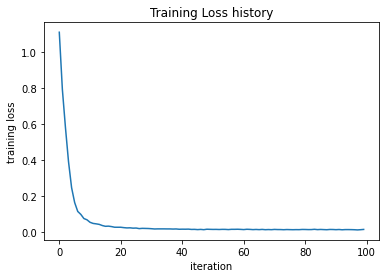

In [160]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Classify CIFAR-10

Do classification on the CIFAR-10 dataset.

In [162]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### Running SGD

If your implementation is correct, you should see a validation accuracy of around 28-29%.

In [167]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# Save this net as the variable subopt_net for later comparison.
subopt_net = net

iteration 0 / 1000: loss 2.302757518613176
iteration 100 / 1000: loss 2.302120159207236
iteration 200 / 1000: loss 2.2956136007408703
iteration 300 / 1000: loss 2.2518259043164135
iteration 400 / 1000: loss 2.188995235046776
iteration 500 / 1000: loss 2.1162527791897747
iteration 600 / 1000: loss 2.064670827698217
iteration 700 / 1000: loss 1.9901688623083942
iteration 800 / 1000: loss 2.002827640124685
iteration 900 / 1000: loss 1.9465176817856495
Validation accuracy:  0.283


## Questions:

The training accuracy isn't great.  

(1) What are some of the reasons why this is the case?  Take the following cell to do some analyses and then report your answers in the cell following the one below.

(2) How should you fix the problems you identified in (1)?


In [168]:
stats['train_acc_history']

[0.095, 0.15, 0.25, 0.25, 0.315]

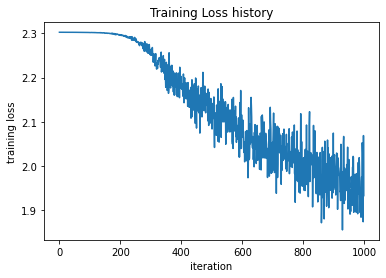

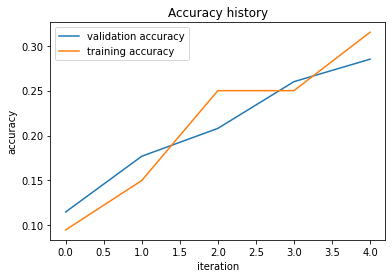

In [171]:
# ================================================================ #
# YOUR CODE HERE:
#   Do some debugging to gain some insight into why the optimization
#   isn't great.
# ================================================================ #

# Plot the loss function and train / validation accuracies

# Graph: Loss vs. Iteration
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Graph: Training accuracy and Validation accuracy vs. Iteration
plt.plot(stats['val_acc_history'], label='validation accuracy')
plt.plot(stats['train_acc_history'], label='training accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('Accuracy history')
plt.legend()
plt.show()

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

## Answers:

(1) The training accuracy is not the best perhaps because the model needs to train for a greater number of iterations. Since the training and validation accuracy are still increasing while loss is still decreasing, there are no signs of overtraining and the model is expected to improve with further training. 

(2) This can be improved by training the model for a greater number of iterations, and/or increasing the learning rate. The fairly linear training loss indicates low learning rate, where as good learning rate should yield a loss curve that is more exponential, decaying faster to a low value before plateauing. In addition, the noisy cost function indicates that the batch size may be a little too low.

## Optimize the neural network

Use the following part of the Jupyter notebook to optimize your hyperparameters on the validation set.  Store your nets as best_net.

In [179]:
best_net = None # store the best model into this 

# ================================================================ #
# YOUR CODE HERE:
#   Optimize over your hyperparameters to arrive at the best neural
#   network.  You should be able to get over 50% validation accuracy.
#   For this part of the notebook, we will give credit based on the
#   accuracy you get.  Your score on this question will be multiplied by:
#      min(floor((X - 28%)) / %22, 1) 
#   where if you get 50% or higher validation accuracy, you get full
#   points.
#
#   Note, you need to use the same network structure (keep hidden_size = 50)!
# ================================================================ #

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=10000, batch_size=200,
            learning_rate=2e-3, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
best_net = net

iteration 0 / 10000: loss 2.30277699762532
iteration 100 / 10000: loss 1.7590223097586706
iteration 200 / 10000: loss 1.649073065982276
iteration 300 / 10000: loss 1.6762319172480356
iteration 400 / 10000: loss 1.612993323184264
iteration 500 / 10000: loss 1.6210144723420281
iteration 600 / 10000: loss 1.514070254883771
iteration 700 / 10000: loss 1.4774067330033271
iteration 800 / 10000: loss 1.5440622181493455
iteration 900 / 10000: loss 1.4779415541983278
iteration 1000 / 10000: loss 1.4416514497443955
iteration 1100 / 10000: loss 1.577367714423431
iteration 1200 / 10000: loss 1.4968606973796912
iteration 1300 / 10000: loss 1.319823653825999
iteration 1400 / 10000: loss 1.3773639178158408
iteration 1500 / 10000: loss 1.4841558005024664
iteration 1600 / 10000: loss 1.445227779767124
iteration 1700 / 10000: loss 1.5136419395755094
iteration 1800 / 10000: loss 1.3263004695031
iteration 1900 / 10000: loss 1.3872988353033355
iteration 2000 / 10000: loss 1.2927478296945654
iteration 2100 

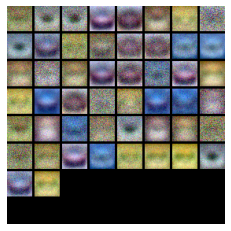

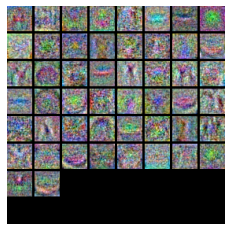

In [175]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.T.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(subopt_net)
show_net_weights(best_net)

## Question:

(1) What differences do you see in the weights between the suboptimal net and the best net you arrived at?

## Answer:

(1) The best net I arrived at has much more complex weights that capture image structure better than the suboptimal net.

## Evaluate on test set 

In [177]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.515


## neural_net.py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network. The net has an input dimension of
  N, a hidden layer dimension of H, and performs classification over C classes.
  We train the network with a softmax loss function and L2 regularization on the
  weight matrices. The network uses a ReLU nonlinearity after the first fully
  connected layer.

  In other words, the network has the following architecture:

  input - fully connected layer - ReLU - fully connected layer - softmax

  The outputs of the second fully-connected layer are the scores for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:

    W1: First layer weights; has shape (H, D)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (C, H)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(hidden_size, input_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(output_size, hidden_size)
    self.params['b2'] = np.zeros(output_size)


  def loss(self, X, y=None, reg=0.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network.

    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Compute the forward pass
    scores = None

    # ================================================================ #
    # YOUR CODE HERE:
	#   Calculate the output scores of the neural network.  The result
	#   should be (N, C). As stated in the description for this class,
	#	there should not be a ReLU layer after the second FC layer.
	#	The output of the second FC layer is the output scores. Do not
	#	use a for loop in your implementation.
    # ================================================================ #
    
    # result should be (5, 3) since N=5 for N training examples, C=3 for C classes
    H1 = np.dot(X, W1.T) + b1 # (5,4)*(4,10) + (10,) = (5,10)
    H1 = np.maximum(np.zeros(H1.shape), H1) # ReLU(x) = max(0,x)
    scores = np.dot(H1, W2.T) + b2 # (5,10)*(10,3) + (3,) = (5,3)
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

  
    # If the targets are not given then jump out, we're done
    if y is None:
        return scores

    # Compute the loss
    loss = None

    # ================================================================ #
    # YOUR CODE HERE:
	#   Calculate the loss of the neural network.  This includes the 
	# 	softmax loss and the L2 regularization for W1 and W2. Store the 
	#	total loss in teh variable loss.  Multiply the regularization
	# 	loss by 0.5 (in addition to the factor reg).
	# ================================================================ #

    # scores is num_examples by num_classes
    num_examples, num_classes = scores.shape
    
    e_A = np.exp(scores)
    summed_e_A = np.sum(e_A, axis=1) # sum across each of 5 rows -> sum per class
    logged_summed_e_A = np.log(summed_e_A)
    A_y = scores[np.arange(num_examples), y] # scores of correct class predictions
    
    regularization = 0.5 * reg * (np.sum(np.square(W1)) + np.sum(np.square(W2))) # sum of squared values of weights
    loss = np.mean(logged_summed_e_A - A_y) + regularization
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    grads = {}

    # ================================================================ #
    # YOUR CODE HERE:
	# 	Implement the backward pass.  Compute the derivatives of the 
	# 	weights and the biases.  Store the results in the grads
	#	dictionary.  e.g., grads['W1'] should store the gradient for 
	# 	W1, and be of the same size as W1.
	# ================================================================ #

    # gradient of softmax without L2 regularization
    softmax_gradient = e_A / summed_e_A.reshape(num_examples, 1)
    softmax_gradient[np.arange(num_examples), y] -= 1
    softmax_gradient /= num_examples # (5,3)
    
    # gradients for L2 regularlization used in loss function
    gradient_reg_W2 = reg * W2 # d(0.5 * reg * (W1**2 + W2**2)) / d(W2) = reg * W2
    gradient_reg_W1 = reg * W1 # d(0.5 * reg * (W1**2 + W2**2)) / d(W1) = reg * W1
    
    grads['b2'] = np.sum(softmax_gradient.T, axis=1) # (3,5) -> sum across each row/class -> (3,) <-> b2=(3,)
    
    gradient_1 = np.dot(H1.T, softmax_gradient).T # d(H1*W2.T) / d(W2.T)
    grads['W2'] = gradient_reg_W2 + gradient_1 # (3,10) <-> W2=(3,10)
   
    gradient_2 = np.dot(softmax_gradient, W2)
    gradient_2[H1 <= 0] = 0 # d(softmax(ReLu(W1.T*X + b1)*W2.T + b2)) / d(W1.T*X + b1)
    
    grads['b1'] = np.sum(gradient_2, axis=0) # (10,) <-> b1=(10,)
    grads['W1'] = gradient_reg_W1 + np.dot(X.T, gradient_2).T # (10,4) <-> W1=(10,4)
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this neural network using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = X.shape[0]
    iterations_per_epoch = max(int(num_train / batch_size), 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in np.arange(num_iters):
      X_batch = None
      y_batch = None

      # ================================================================ #
      # YOUR CODE HERE:
  	  # 	Create a minibatch by sampling batch_size samples randomly.
  	  # ================================================================ #

      idxs = np.random.choice(num_train, batch_size, replace=True) # replace like in HW2?
      X_batch = X[idxs]
      y_batch = y[idxs]

      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

       # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      # ================================================================ #
      # YOUR CODE HERE:
  	  # 	Perform a gradient descent step using the minibatch to update
	  # 	all parameters (i.e., W1, W2, b1, and b2).
  	  # ================================================================ #

      self.params['W1'] -= learning_rate * grads['W1']
      self.params['b1'] -= learning_rate * grads['b1']
      self.params['W2'] -= learning_rate * grads['W2']
      self.params['b2'] -= learning_rate * grads['b2']

      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      if verbose and it % 100 == 0:
        print('iteration {} / {}: loss {}'.format(it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.

    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.

    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    y_pred = None

    # ================================================================ #
    # YOUR CODE HERE:
    # 	Predict the class given the input data.
    # ================================================================ #
    
    H1 = np.dot(X, self.params['W1'].T) + self.params['b1'] # (5,4)*(4,10) + (10,) = (5,10)
    H1 = np.maximum(np.zeros(H1.shape), H1) # ReLU(x) = max(0,x)
    scores = np.dot(H1, self.params['W2'].T) + self.params['b2'] # (5,10)*(10,3) + (3,) = (5 examples, 3 classes)
    
    y_pred = np.argmax(scores, axis=1) # maximum value per row = class with highest score

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return y_pred